In [1]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algorithms'''
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

In [2]:
# Load the data
current_path = os.getcwd()
file = '\\datasets\\lending_club_data\\LoanStats3a.csv'
data = pd.read_csv(current_path + file)

C:\Users\ankur_\Anaconda3\envs\unsupervisedLearning\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Select columns to keep
columnsToKeep = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                 'int_rate','installment','grade','sub_grade', \
                 'emp_length','home_ownership','annual_inc', \
                 'verification_status','pymnt_plan','purpose', \
                 'addr_state','dti','delinq_2yrs','earliest_cr_line', \
                 'mths_since_last_delinq','mths_since_last_record', \
                 'open_acc','pub_rec','revol_bal','revol_util', \
                 'total_acc','initial_list_status','out_prncp', \
                 'out_prncp_inv','total_pymnt','total_pymnt_inv', \
                 'total_rec_prncp','total_rec_int','total_rec_late_fee', \
                 'recoveries','collection_recovery_fee','last_pymnt_d', \
                 'last_pymnt_amnt']

data = data.loc[:,columnsToKeep]

In [4]:
data.shape

(42542, 37)

In [5]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,...,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-14,649.91
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,...,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-15,357.48
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,...,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,Jan-17,67.30


In [6]:
# Transform features from string to numeric
for i in ["term","int_rate","emp_length","revol_util"]:
    data.loc[:,i] = \
        data.loc[:,i].apply(lambda x: re.sub("[^0-9]", "", str(x)))
    data.loc[:,i] = pd.to_numeric(data.loc[:,i])

In [7]:
# Determine which features are numerical
numericalFeats = [x for x in data.columns if data[x].dtype != 'object']

In [8]:
# Display NaNs by feature
nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                      7
funded_amnt                    7
funded_amnt_inv                7
term                           7
int_rate                       7
installment                    7
emp_length                  1119
annual_inc                    11
dti                            7
delinq_2yrs                   36
mths_since_last_delinq     26933
mths_since_last_record     38891
open_acc                      36
pub_rec                       36
revol_bal                      7
revol_util                    97
total_acc                     36
out_prncp                      7
out_prncp_inv                  7
total_pymnt                    7
total_pymnt_inv                7
total_rec_prncp                7
total_rec_int                  7
total_rec_late_fee             7
recoveries                     7
collection_recovery_fee        7
last_pymnt_amnt                7
dtype: int64

In [9]:
# Impute NaNs with mean 
fillWithMean = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                'int_rate','installment','emp_length','annual_inc',\
                'dti','open_acc','revol_bal','revol_util','total_acc',\
                'out_prncp','out_prncp_inv','total_pymnt', \
                'total_pymnt_inv','total_rec_prncp','total_rec_int', \
                'last_pymnt_amnt']

# Impute NaNs with zero
fillWithZero = ['delinq_2yrs','mths_since_last_delinq', \
                'mths_since_last_record','pub_rec','total_rec_late_fee', \
                'recoveries','collection_recovery_fee']

# Perform imputation
im = pp.Imputer(strategy='mean')   
data.loc[:,fillWithMean] = im.fit_transform(data[fillWithMean])

data.loc[:,fillWithZero] = data.loc[:,fillWithZero].fillna(value=0,axis=1)

In [10]:
# Check for NaNs one last time
nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
emp_length                 0
annual_inc                 0
dti                        0
delinq_2yrs                0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
dtype: int64

In [11]:
# Feature engineering
data['installmentOverLoanAmnt'] = data.installment/data.loan_amnt
data['loanAmntOverIncome'] = data.loan_amnt/data.annual_inc
data['revol_balOverIncome'] = data.revol_bal/data.annual_inc
data['totalPymntOverIncome'] = data.total_pymnt/data.annual_inc
data['totalPymntInvOverIncome'] = data.total_pymnt_inv/data.annual_inc
data['totalRecPrncpOverIncome'] = data.total_rec_prncp/data.annual_inc
data['totalRecIncOverIncome'] = data.total_rec_int/data.annual_inc

newFeats = ['installmentOverLoanAmnt','loanAmntOverIncome', \
            'revol_balOverIncome','totalPymntOverIncome', \
           'totalPymntInvOverIncome','totalRecPrncpOverIncome', \
            'totalRecIncOverIncome']

In [12]:
# Select features for training
numericalPlusNewFeats = numericalFeats+newFeats
X_train = data.loc[:,numericalPlusNewFeats]

# Scale data
sX = pp.StandardScaler()
X_train.loc[:,:] = sX.fit_transform(X_train)

In [13]:
X_train.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'installmentOverLoanAmnt',
       'loanAmntOverIncome', 'revol_balOverIncome', 'totalPymntOverIncome',
       'totalPymntInvOverIncome', 'totalRecPrncpOverIncome',
       'totalRecIncOverIncome'],
      dtype='object')

In [14]:
# Designate labels for evaluation
labels = data.grade
labels.unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G', nan], dtype=object)

In [15]:
# Fill missing labels
labels = labels.fillna(value="Z")

# Convert labels to numerical values
lbl = pp.LabelEncoder()
lbl.fit(list(labels.values))
labels = pd.Series(data=lbl.transform(labels.values), name="grade")

# Store as y_train
y_train = labels

In [16]:
labelsOriginalVSNew = pd.concat([labels, data.grade],axis=1)
labelsOriginalVSNew

,grade,grade
0,1,B
1,2,C
2,2,C
3,2,C
4,1,B
5,0,A
6,2,C
7,4,E
8,5,F
9,1,B


In [17]:
# Compare loan grades with interest rates
interestAndGrade = pd.DataFrame(data=[data.int_rate,labels])
interestAndGrade = interestAndGrade.T

interestAndGrade.groupby("grade").mean()

,int_rate
grade,
0.0,734.270844
1.0,1101.420857
2.0,1349.988902
3.0,1557.714927
4.0,1737.676783
5.0,1926.530361
6.0,2045.125000
7.0,1216.501563


In [18]:
# Goodness of the Clusters

In [19]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = \
        pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg( \
        lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, \
        left_on="cluster",right_on="cluster")
    
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ \
        accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/ \
        accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, \
        accuracyDF, overallAccuracy, accuracyByLabel

In [47]:
# K-means Application

In [48]:
from sklearn.cluster import KMeans

n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, \
                random_state=random_state, n_jobs=n_jobs)

kMeans_inertia = pd.DataFrame(data=[],index=range(10,31), \
                              columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[], \
    index=range(10,31),columns=['overallAccuracy'])

for n_clusters in range(10,31):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                    max_iter=max_iter, tol=tol, \
                    random_state=random_state, n_jobs=n_jobs)

    kmeans.fit(X_train)
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train)
    X_train_kmeansClustered = pd.DataFrame(data= \
        X_train_kmeansClustered, index=X_train.index, \
        columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, \
    countMostFreq_kMeans, accuracyDF_kMeans, \
    overallAccuracy_kMeans, accuracyByLabel_kMeans = \
    analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = \
        overallAccuracy_kMeans

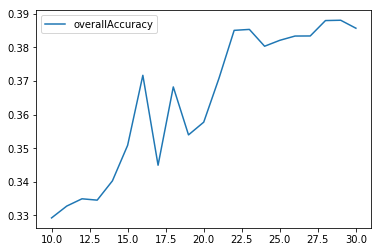

In [49]:
overallAccuracy_kMeansDF.plot()

In [50]:
accuracyByLabel_kMeans

0     0.326633
1     0.258993
2     0.292240
3     0.234242
4     0.388794
5     0.325654
6     0.303797
7     0.762116
8     0.222222
9     0.391381
10    0.292910
11    0.317533
12    0.206897
13    0.312709
14    0.345233
15    0.682208
16    0.327250
17    0.366605
18    0.234783
19    0.288757
20    0.500000
21    0.375466
22    0.332203
23    0.252252
24    0.338509
25    0.232000
26    0.464418
27    0.261583
28    0.376327
29    0.269129
dtype: float64

In [ ]:
# Hierarchical Clustering Application

In [20]:
import fastcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Z = fastcluster.linkage_vector(X_train, method='ward', \
                               metric='euclidean')

Z_dataFrame = pd.DataFrame(data=Z,columns=['clusterOne', \
                'clusterTwo','distance','newClusterSize'])

In [21]:
Z_dataFrame[:20]

,clusterOne,clusterTwo,distance,newClusterSize
0,39786.0,39787.0,0.000000e+00,2.0
1,39788.0,42542.0,0.000000e+00,3.0
2,42538.0,42539.0,0.000000e+00,2.0
3,42540.0,42544.0,0.000000e+00,3.0
4,42541.0,42545.0,3.399350e-17,4.0
5,42543.0,42546.0,5.139334e-17,7.0
6,33251.0,33261.0,1.561313e-01,2.0
7,42512.0,42535.0,3.342654e-01,2.0
8,42219.0,42316.0,3.368231e-01,2.0
9,6112.0,21928.0,3.384368e-01,2.0


In [22]:
Z_dataFrame[42521:]

,clusterOne,clusterTwo,distance,newClusterSize
42521,85038.0,85043.0,132.715723,3969.0
42522,85051.0,85052.0,141.386569,2899.0
42523,85026.0,85027.0,146.976703,2351.0
42524,85048.0,85049.0,152.660192,5691.0
42525,85036.0,85059.0,153.512281,5956.0
42526,85033.0,85044.0,160.825959,2203.0
42527,85055.0,85061.0,163.701428,668.0
42528,85062.0,85066.0,168.199295,6897.0
42529,85054.0,85060.0,168.924039,9414.0
42530,85028.0,85064.0,185.215769,3118.0


In [23]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 100
clusters = fcluster(Z, distance_threshold, criterion='distance')
X_train_hierClustered = pd.DataFrame(data=clusters, \
    index=X_train.index,columns=['cluster'])

In [24]:
print("Number of distinct clusters: ", \
      len(X_train_hierClustered['cluster'].unique()))

Number of distinct clusters:  32


In [25]:
countByCluster_hierClust, countByLabel_hierClust, \
    countMostFreq_hierClust, accuracyDF_hierClust, \
    overallAccuracy_hierClust, accuracyByLabel_hierClust = \
    analyzeCluster(X_train_hierClustered, y_train)

print("Overall accuracy from hierarchical clustering: ", \
      overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.3651685393258427


In [26]:
print("Accuracy by cluster for hierarchical clustering")
accuracyByLabel_hierClust

Accuracy by cluster for hierarchical clustering


0     0.304124
1     0.219001
2     0.228311
3     0.379722
4     0.240064
5     0.272011
6     0.314560
7     0.263930
8     0.246138
9     0.318942
10    0.302752
11    0.269772
12    0.335717
13    0.330403
14    0.346320
15    0.440141
16    0.744155
17    0.502227
18    0.294118
19    0.236111
20    0.254727
21    0.241042
22    0.317979
23    0.308771
24    0.284314
25    0.243243
26    0.500000
27    0.289157
28    0.365283
29    0.479693
30    0.393559
31    0.340875
dtype: float64

In [ ]:
# HDBSCAN Application

In [31]:
import hdbscan

min_cluster_size = 20
min_samples = 20
alpha = 1.0
cluster_selection_method = 'leaf'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
    min_samples=min_samples, alpha=alpha, \
    cluster_selection_method=cluster_selection_method)

X_train_hdbscanClustered = hdb.fit_predict(X_train)
X_train_hdbscanClustered = pd.DataFrame(data= \
    X_train_hdbscanClustered, index=X_train.index, \
    columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, \
    countMostFreq_hdbscan, accuracyDF_hdbscan, \
    overallAccuracy_hdbscan, accuracyByLabel_hdbscan = \
    analyzeCluster(X_train_hdbscanClustered, y_train)

In [32]:
print("Overall accuracy from HDBSCAN: ", overallAccuracy_hdbscan)

Overall accuracy from HDBSCAN:  0.3246203751586667


In [33]:
print("Cluster results for HDBSCAN")
countByCluster_hdbscan

Cluster results for HDBSCAN


,cluster,clusterCount
0,-1,32708
1,7,4070
2,2,3668
3,1,1096
4,4,773
5,0,120
6,6,49
7,3,38
8,5,20


In [34]:
accuracyByLabel_hdbscan

0    0.284487
1    0.341667
2    0.414234
3    0.332061
4    0.552632
5    0.438551
6    0.400000
7    0.408163
8    0.590663
dtype: float64